# Advanced First-Order Second-Moment Methods

Created by Michael J. Quevillon (mquevill@nd.edu)
2020-07-07

All figures and examples shown here are from *Uncertainty Quantification and Predictive Computational Science* (2018) by Ryan G. McClarren

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.stats import gumbel_r, norm

## Gumbel Distribution

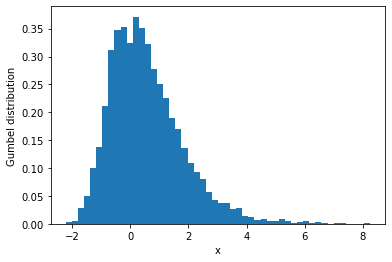

In [2]:
N = 5000
gumbel = gumbel_r.rvs(size=N)
plt.hist(gumbel, bins=50, density=True)
plt.xlabel("x")
plt.ylabel("Gumbel distribution")
plt.show()

## Advanced FOSM

FOSM is independent of the underlying distributions. As we have learned, two distributions can have the same mean and variance and still be wildly different in their overall distributions. Advanced FOSMs *try* to incorporate the true underlying distributions.

### Example QoI

$Q(\mathbf{x}) = 2 x_1^3 + 10 x_1 x_2 + x_1 + 3 x_2^2 + x_1$

In [3]:
def checksize2(x):
    if np.array(x).size != 2:
        raise InputError("Input to Q(x) must be of size 2.")

def Q(x):
    checksize2(x)
    return 2*x[0]**3 + 10*x[0]*x[1] + x[0] + 3*x[1]**3 + x[1]

def delxQ(x):
    checksize2(x)
    return np.array([
        6*x[0]**2 + 10*x[1] + 1,
        10*x[0] + 9*x[1]**2 + 1
    ])

def y(x, mean, var):
    checksize2(x)
    checksize2(mean)
    checksize2(var)
    return np.divide(x - mean, var)

def x(y, mean, var):
    checksize2(y)
    checksize2(mean)
    checksize2(var)
    return np.multiply(y, var) + mean
    
# y = (x-mean)/var
# dx/dy = var
# dely is just var*delx
def delyQ(x, var):
    checksize2(var)
    return np.multiply(delxQ(x), var)
    

### Example for Fig 8.6

This example shows AFOSM with two variables that have a multivariate normal distribution. The off-diagonal terms in the covariance and correlation matrices indicate that these variables are **not** independent!

In [4]:
# values from the book
mean = np.array([0.1, -0.05]) 
sigma = np.array([[4, 3.9],[3.9, 9]])
var = np.sqrt(np.diagonal(sigma))
R = np.array([[1, 0.65],[0.65, 1]])
Qfail = 100

tol = 1e-6
delta = tol
eps = tol

In [5]:
def AFOSM_gaussian(x0, iters=25):
    xcurr = np.array(x0)
    betacurr = 1000 # arbitrarily large value

    betas = np.empty(N+1)
    betas[:] = np.nan
    betas[0] = betacurr
    X = np.empty((2, N+1))
    X[:] = np.nan
    X[:, 0] = xcurr

    isConverged = False
    for l in range(N):
        ycurr = y(xcurr, mean, var)
        dyQ = delyQ(xcurr, var)
        lamb = (Qfail - Q(xcurr) + dyQ @ ycurr)/(dyQ @ R @ np.transpose(dyQ))
        ynext = lamb * R @ np.transpose(dyQ)
        betanext = np.sqrt(np.transpose(ynext) @ np.linalg.inv(R) @ ynext)
        xnext = x(ynext, mean, var)
        if np.abs(betanext - betacurr) < delta and np.abs(Q(xnext) - Qfail) < eps:
            isConverged = True
            break
        betacurr = betanext
        xcurr = xnext
        X[:, l+1] = xnext
        betas[l+1] = betanext

    if not isConverged:
        print(f"AFOSM did not converge in {N} iterations!")

    X = X[:,~np.isnan(X).any(axis=0)]
    betas = betas[~np.isnan(betas)]
    return X, betas

Using all of these functions we have defined, we can then just put an initial guess into this to recreate the figures from the book.

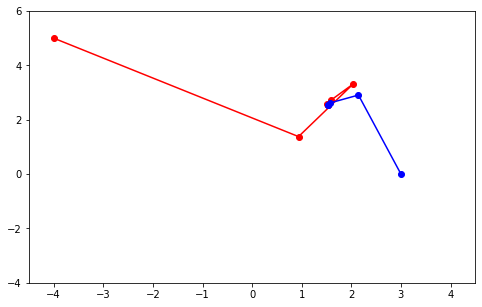

In [6]:
plt.figure(figsize=(8,5))
xred, _ = AFOSM_gaussian([-4, 5])
plt.plot( xred[0,:],  xred[1,:], marker="o", color="r")
xblue, _ = AFOSM_gaussian([3, 0])
plt.plot(xblue[0,:], xblue[1,:], marker="o", color="b")
plt.xlim([-4.5,4.5]); plt.ylim([-4,6])
plt.show()

![Figure 8.6](figures/Fig-8.6.png)

This is a relatively simple story, but there's more to this story...

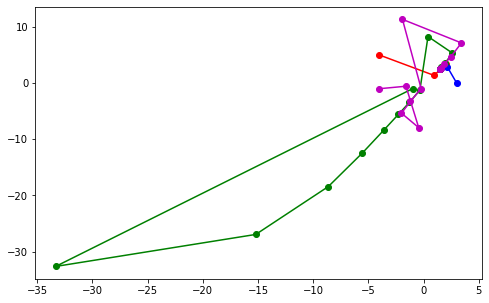

In [7]:
plt.figure(figsize=(8,5))
xred, _ = AFOSM_gaussian([-4, 5])
plt.plot( xred[0,:],  xred[1,:], marker="o", color="r")
xblue, _ = AFOSM_gaussian([3, 0])
plt.plot(xblue[0,:], xblue[1,:], marker="o", color="b")
xgreen, _ = AFOSM_gaussian([-1,-1])
plt.plot(xgreen[0,:], xgreen[1,:], marker="o", color="g")
xpurple, _ = AFOSM_gaussian([-4,-1])
plt.plot(xpurple[0,:], xpurple[1,:], marker="o", color="m")
plt.show()

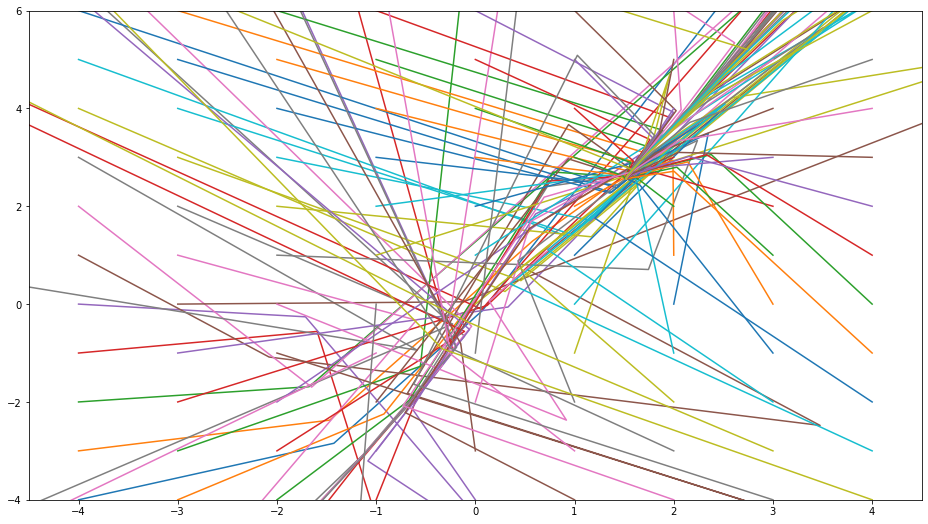

In [8]:
import itertools

lx = np.linspace(-4, 4, 9)
ly = np.linspace(-4, 6, 11)
# lx = [-4]
# ly = [1]
plt.figure(figsize=(16,9))
for pt in itertools.product(lx, ly):
    X, b = AFOSM_gaussian(pt)
#     plt.plot(X[0,-1], X[1,-1], marker="o")
    plt.plot(X[0,:], X[1,:])
plt.xlim([-4.5,4.5]); plt.ylim([-4,6])
plt.show()

Using basic FOSM, we get that the probability of failure is functionally zero, because the estimate of beta from Eq. (8.5) (basic FOSM) is 14.6.

Since the point of interest has $Q << Q_{fail}$, AFOSM is necessary to determine the point of failure.

### Example for Fig. 8.7

This example shows AFOSM with two independent variables that each have a Gumbel distribution.

**NOT CURRENTLY WORKING**

In [9]:
# All other input parameters are kept the same
R = np.array([[1, 0],[0, 1]]) # completely independent!

In [10]:
def gumbel_std(x, mean):
    var = np.empty(2)
    for i,_ in enumerate(x):
        var[i] = norm.pdf(norm.ppf(gumbel_r.cdf(x[i], loc=mean[i]), loc=mean[i]), loc=mean[i])/gumbel_r.pdf(x[i], loc=mean[i])
    return var

In [11]:
def AFOSM_gumbel(x0, iters=100):
    xcurr = np.array(x0)
    betacurr = 1000 # arbitrarily large value

    betas = np.empty(N+1)
    betas[:] = np.nan
    betas[0] = betacurr
    X = np.empty((2, N+1))
    X[:] = np.nan
    X[:, 0] = xcurr

    isConverged = False
    for l in range(N):
        mean_g = gumbel_r.median(loc=mean)
        var_g = gumbel_std(xcurr, mean_g)
        ycurr = y(xcurr, mean_g, var_g)
        dyQ = delyQ(xcurr, var_g)
        lamb = (Qfail - Q(xcurr) + dyQ @ ycurr)/(dyQ @ R @ np.transpose(dyQ))
        ynext = lamb * R @ np.transpose(dyQ)
        betanext = np.sqrt(np.transpose(ynext) @ np.linalg.inv(R) @ ynext)
        xnext = x(ynext, mean_g, var_g)
        if np.abs(betanext - betacurr) < delta and np.abs(Q(xnext) - Qfail) < eps:
            isConverged = True
            break
        betacurr = betanext
        xcurr = xnext
        X[:, l+1] = xnext
        betas[l+1] = betanext

    if not isConverged:
        print(f"AFOSM did not converge in {N} iterations!")

    X = X[:,~np.isnan(X).any(axis=0)]
    betas = betas[~np.isnan(betas)]
    return X, betas

[1.00000000e+03 5.29148312e-01 2.19688931e+00 1.25810732e+00
 1.31375312e+00 1.33611933e+00 1.33791245e+00 1.33830112e+00
 1.33843757e+00 1.33848586e+00 1.33850297e+00 1.33850904e+00
 1.33851120e+00]


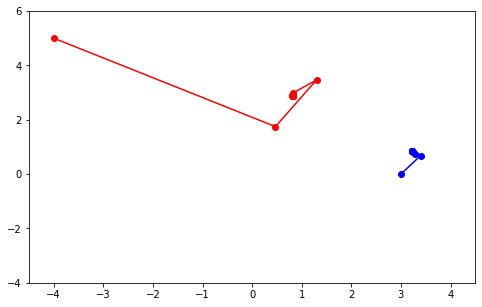

In [12]:
plt.figure(figsize=(8,5))
xred, betas = AFOSM_gumbel([-4, 5])
print(betas)
plt.plot( xred[0,:],  xred[1,:], marker="o", color="r")
xblue, _ = AFOSM_gumbel([3, 0])
plt.plot(xblue[0,:], xblue[1,:], marker="o", color="b")
plt.xlim([-4.5,4.5]); plt.ylim([-4,6])
plt.show()

![Figure 8.7](figures/Fig-8.7.png)